In [1]:
# library calling dataset
import pandas as pd
import numpy as np 

# library visualization
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image
import glob, cv2, os
import pathlib

# library preprocessing data
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping ,LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# library model definition and training algoritma
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.optimizers.legacy import Adam,SGD,RMSprop
from tensorflow.keras.regularizers import l2
# library model evaluation
from sklearn.metrics import classification_report , confusion_matrix

2024-01-01 17:59:54.402208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 17:59:55.517360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the path to your dataset directory
train_dir = './pomegranateData/train/'

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,

#     fill_mode='nearest',
#     validation_split=0.3  # 80% training, 20% validation
# )

# Create an ImageDataGenerator with normalization
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to be between 0 and 1
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
#     fill_mode='nearest',
    validation_split=0.2,  # Split the dataset into 80% training and 20% validation
)

# Create training dataset
train_dataset = image_generator.flow_from_directory(
    train_dir,
    batch_size=15,  # Adjust the batch size as needed
    class_mode='categorical',  # Use 'binary' for binary classification
    subset='training'  # Specify this is the training set
)

# Create validation dataset
validation_dataset = image_generator.flow_from_directory(
    train_dir,
    batch_size=15,
    class_mode='categorical',
    subset='validation'  # Specify this is the validation set
)

# Define the path to your test set directory
test_dir = './pomegranateData/test/'

# Create an ImageDataGenerator with normalization (if needed)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Create a test dataset generator
test_data = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # Adjust the target size to match your model's input size
    batch_size=10,  # Adjust the batch size as needed
    class_mode='categorical',  # Use 'binary' for binary classification
    shuffle=False  # Do not shuffle for confusion matrix
)

Found 1440 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [3]:
print(test_data.class_indices)

{'Pomegranate_Bad': 0, 'Pomegranate_Good': 1}


In [4]:
# CNN Initialization
model = tf.keras.models.Sequential()

# configuration layer 1
model.add(Conv2D(64, 3, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha=0.001),input_shape=(256,256,3))) # number of features/adjust the data, if the color image is added the number 3
model.add(BatchNormalization())
model.add(MaxPool2D(2)) # Maxpool with 2x2 matrix

#configuration layer 2
model.add(Conv2D(64, 3, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

# configuration layer 3
model.add(Conv2D(32, 3, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

# configuration layer 4
# model.add(Conv2D(64, 3, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha = 0.001)))
# model.add(BatchNormalization())
# model.add(MaxPool2D(2))

# # configuration layer 5
# model.add(Conv2D(128, 3, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha = 0.005)))
# model.add(BatchNormalization())
# model.add(MaxPool2D(5))

# flattend
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

2024-01-01 17:59:58.127079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-01 17:59:58.253566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-01 17:59:58.253909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

# lr_scheduler = LearningRateScheduler(lr_schedule)
# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001,rho=0.5,epsilon=0.005), metrics=['accuracy'])

# # model compile
# model.compile(loss="categorical_crossentropy",
#               optimizer=SGD(learning_rate= 0.00001,momentum=0.5),metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                        

In [7]:
# Set up ModelCheckpoint callback
checkpoint_filepath = '.models/bestPomegranateModel01.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, 
                             monitor='val_accuracy',  # Monitor validation accuracy
                             save_best_only=True,     # Save only the best models
                             mode='max',              # Save when the monitored metric is at its maximum
                             verbose=1)

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [9]:
# training model

%time

project = model.fit(train_dataset, epochs = 100, verbose=1, validation_data = validation_dataset, callbacks=[checkpoint])

CPU times: user 13 µs, sys: 4 µs, total: 17 µs
Wall time: 31.2 µs
Epoch 1/100


2024-01-01 18:00:01.067739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-01-01 18:00:01.215873: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-01 18:00:01.216786: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-01 18:00:01.218426: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-01 18:00:01.219049: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-01 18:00:01.221124: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes


 1/96 [..............................] - ETA: 6:31 - loss: 7.1441 - accuracy: 0.2667

2024-01-01 18:00:03.458155: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-01 18:00:03.458201: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


96/96 [==============================] - ETA: 0s - loss: 5.3979 - accuracy: 0.4944
Epoch 1: val_accuracy improved from -inf to 0.42778, saving model to /media/jayanth/Data/Abhi/7th sem/miniProject/savedModel/bestPomegranateModel01.h5


/home/jayanth/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 74s 734ms/step - loss: 5.3979 - accuracy: 0.4944 - val_loss: 4.9171 - val_accuracy: 0.4278
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 5.1470 - accuracy: 0.5431
Epoch 2: val_accuracy improved from 0.42778 to 0.50556, saving model to /media/jayanth/Data/Abhi/7th sem/miniProject/savedModel/bestPomegranateModel01.h5
96/96 [==============================] - 26s 272ms/step - loss: 5.1470 - accuracy: 0.5431 - val_loss: 4.9061 - val_accuracy: 0.5056
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 4.9887 - accuracy: 0.6076
Epoch 3: val_accuracy improved from 0.50556 to 0.50833, saving model to /media/jayanth/Data/Abhi/7th sem/miniProject/savedModel/bestPomegranateModel01.h5
96/96 [==============================] - 26s 266ms/step - loss: 4.9887 - accuracy: 0.6076 - val_loss: 4.8927 - val_accuracy: 0.5083
Epoch 4/100
96/96 [==============================] - ETA: 0s - loss: 4.8796 - accuracy: 0.6528
Epoch 4: va

96/96 [==============================] - ETA: 0s - loss: 4.4217 - accuracy: 0.8667
Epoch 25: val_accuracy did not improve from 0.97500
96/96 [==============================] - 26s 270ms/step - loss: 4.4217 - accuracy: 0.8667 - val_loss: 4.2558 - val_accuracy: 0.9750
Epoch 26/100
96/96 [==============================] - ETA: 0s - loss: 4.4255 - accuracy: 0.8681
Epoch 26: val_accuracy improved from 0.97500 to 0.97778, saving model to /media/jayanth/Data/Abhi/7th sem/miniProject/savedModel/bestPomegranateModel01.h5
96/96 [==============================] - 27s 280ms/step - loss: 4.4255 - accuracy: 0.8681 - val_loss: 4.2419 - val_accuracy: 0.9778
Epoch 27/100
96/96 [==============================] - ETA: 0s - loss: 4.4276 - accuracy: 0.8729
Epoch 27: val_accuracy improved from 0.97778 to 0.98056, saving model to /media/jayanth/Data/Abhi/7th sem/miniProject/savedModel/bestPomegranateModel01.h5
96/96 [==============================] - 26s 275ms/step - loss: 4.4276 - accuracy: 0.8729 - val_los

96/96 [==============================] - ETA: 0s - loss: 4.2460 - accuracy: 0.9049
Epoch 52: val_accuracy did not improve from 1.00000
96/96 [==============================] - 62s 647ms/step - loss: 4.2460 - accuracy: 0.9049 - val_loss: 4.0527 - val_accuracy: 0.9972
Epoch 53/100
96/96 [==============================] - ETA: 0s - loss: 4.2322 - accuracy: 0.8924
Epoch 53: val_accuracy did not improve from 1.00000
96/96 [==============================] - 62s 646ms/step - loss: 4.2322 - accuracy: 0.8924 - val_loss: 4.0503 - val_accuracy: 0.9972
Epoch 54/100
96/96 [==============================] - ETA: 0s - loss: 4.2330 - accuracy: 0.8993
Epoch 54: val_accuracy did not improve from 1.00000
96/96 [==============================] - 64s 661ms/step - loss: 4.2330 - accuracy: 0.8993 - val_loss: 4.0435 - val_accuracy: 0.9944
Epoch 55/100
96/96 [==============================] - ETA: 0s - loss: 4.2128 - accuracy: 0.9021
Epoch 55: val_accuracy did not improve from 1.00000
96/96 [==================

96/96 [==============================] - ETA: 0s - loss: 4.0071 - accuracy: 0.9292
Epoch 81: val_accuracy did not improve from 1.00000
96/96 [==============================] - 21s 216ms/step - loss: 4.0071 - accuracy: 0.9292 - val_loss: 3.8606 - val_accuracy: 1.0000
Epoch 82/100
96/96 [==============================] - ETA: 0s - loss: 4.0207 - accuracy: 0.9215
Epoch 82: val_accuracy did not improve from 1.00000
96/96 [==============================] - 21s 217ms/step - loss: 4.0207 - accuracy: 0.9215 - val_loss: 3.8582 - val_accuracy: 0.9972
Epoch 83/100
96/96 [==============================] - ETA: 0s - loss: 4.0008 - accuracy: 0.9271
Epoch 83: val_accuracy did not improve from 1.00000
96/96 [==============================] - 21s 221ms/step - loss: 4.0008 - accuracy: 0.9271 - val_loss: 3.8498 - val_accuracy: 0.9972
Epoch 84/100
96/96 [==============================] - ETA: 0s - loss: 4.0054 - accuracy: 0.9208
Epoch 84: val_accuracy did not improve from 1.00000
96/96 [==================

In [10]:
history = project.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

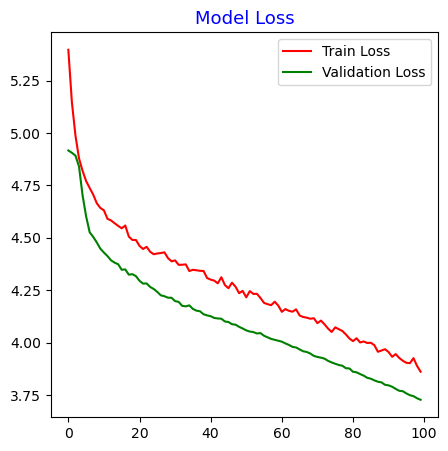

In [11]:
plt.figure(figsize=(5,5))
plt.plot(history["loss"],label = "Train Loss", color = "red")
plt.plot(history["val_loss"],label = "Validation Loss",color = "green")
plt.title("Model Loss", color = "blue", size = 13)
plt.legend()
plt.show()

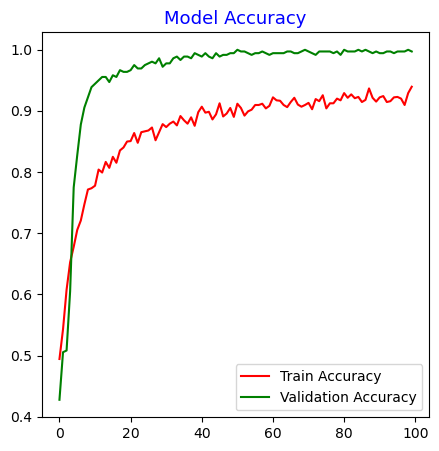

In [12]:
plt.figure(figsize=(5,5))
plt.plot(history["accuracy"],label = "Train Accuracy", color = "red")
plt.plot(history["val_accuracy"],label = "Validation Accuracy", color = "green")
plt.title("Model Accuracy", color = "blue", size = 13)
plt.legend()
plt.show()

20/20 [==============================] - 6s 287ms/step


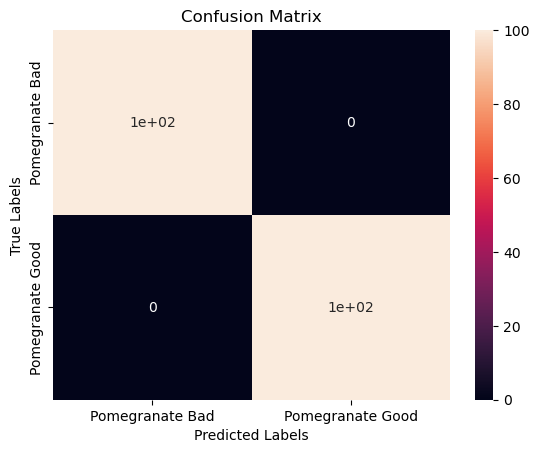

                  precision    recall  f1-score   support

 Pomegranate_Bad       1.00      1.00      1.00       100
Pomegranate_Good       1.00      1.00      1.00       100

        accuracy                           1.00       200
       macro avg       1.00      1.00      1.00       200
    weighted avg       1.00      1.00      1.00       200



In [13]:
# Make predictions on the test set
y_pred = model.predict(test_data)

# Convert the one-hot encoded labels to class labels
y_true = test_data.classes
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

import seaborn as sns
lables = ['Pomegranate Bad', 'Pomegranate Good']
sns.heatmap(conf_matrix, annot=True, 
            xticklabels= lables,
            yticklabels= lables)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

class_names = list(test_data.class_indices.keys())
# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [14]:
# load json module
import json

# create json object from dictionary
json = json.dumps(history)

# open file for writing, "w" 
f = open("pomegranateTraining.json","w")

# write json object to file
f.write(json)

# close file
f.close()